In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from enum import IntEnum
import random
import math
from math import exp
import numpy as np


import math
from queue import PriorityQueue
from random import expovariate, shuffle, uniform, randint
import copy
from matplotlib.backends.qt_compat import QtCore, QtWidgets
from matplotlib.backends.backend_qt5agg import (FigureCanvas, NavigationToolbar2QT as NavigationToolbar)
from functools import partial

In [2]:
class NodeType(IntEnum):
    Common=1,
    Bot=2,
    Influencer=3
def norm_sample(avg=0.0, var=0.4, clip1=-1, clip2=1, n=None):
    norm_vals = np.random.normal(avg, var, n)  # sample from a normal distribution
    return np.clip(norm_vals, clip1, clip2)  # limit the results into [0, 1]

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

class Edge:
    def __init__(self, start, dest, weight):
        self.start = start
        self.dest = dest
        self.weight = weight
class Node:
    def __init__(self,ids,node_type):
        self.id=ids
        self.type=node_type
        self.adj = []
        #self.score = np.random.uniform(-1, 1) #####define the node's political stand left or right, or their tendency in beliveving sth
        self.score=0
        self.position_x = np.random.uniform(0, 1)  #######position of x and y define people's abstract distance
        self.position_y = np.random.uniform(0, 1)
        self.message_queue = [] ###use to store information or effect on the node
        self.vulnerability = norm_sample(avg=0.5, var=0.1, clip1=0, clip2=1)
        self.reshare_rate = norm_sample(avg=0.5, var=0.1, clip1=0, clip2=1)
        self.recover_rate = norm_sample(avg=0.2, var=0.1, clip1=0, clip2=1)
        self.recovery_time = None
        self.infection_time = None
        if node_type == NodeType.Bot:
            self.infection_time = 0
    def add_adj(self,edge):
        self.adj.append(edge)
    def compute_distance(self,node_b):
        a = np.array([self.position_x, self.position_y])
        b = np.array([node_b.position_x, node_b.position_y])
        return euclidean_distance(a, b)/np.sqrt(2)
    def update(self):
        s = sum(self.message_queue)
        l = len(self.message_queue)
        self.message_queue = []
        if l > 0:
            avg = s / l
            self.score += avg
            if self.score > 1:
                self.score = 1
            elif self.score < - 1:
                self.score = -1
            return True
        else:
            return False
    def update_sir(self, engagement_news):
        number_of_messages = len(self.message_queue)
        if self.type == NodeType.Bot:
            return

        if number_of_messages != 0 and self.score != -1:
            can_fact_check = False

            for i in range(number_of_messages):
                p = random.uniform(0, 1)
                message_type, weight = self.message_queue[i]

                if message_type == -1:
                    k = 0.1
                else:
                    k = 1
                    can_fact_check = True

                if p < self.vulnerability * k * weight * engagement_news:
                    self.score = message_type
                    can_fact_check = False
                    
            if can_fact_check and self.score == 0:
                self.is_recovered()

        self.message_queue = []
    def __str__(self):
        return '{} - deg: {}\n' \
               '\tinterests: {}\n' \
               '\tscore: {}\n' \
               '\tx: {} y: {}'.format(
                self.id, len(self.adj), self.score,
                self.position_x, self.position_y)
class Network:
    def __init__(self,N_common, N_influencers, N_bots, random_const):
        self.N_common=N_common
        self.N_influencers=N_influencers
        self.N_bots=N_bots
        self.nodes={}
        self.available_id=0
        self.infected_node=None
    def gen_node(self,node_type):
        idx=self.available_id
        node=Node(idx,node_type)
        self.available_id+=1
        self.nodes[node.id]=node
        if node_type==NodeType.Influencer: ####define node property 
            pass
        if node_type==NodeType.Bot: ####define node property 
            node.reshare_rate = 1
        return idx
    def generate_common(self,random_const):
        def add_proximity_edge(idx_a, idx_b, dist, random_const):
            prox = (1 - dist)
            #edge = list(filter(lambda x: x.dest == idx_b, self.nodes[idx_a].adj))
            p = random.uniform(0, 1)
            if dist < random_const and p < 0.3:  ##people need to have close enough distance to be connected and a finite probability
                weight = prox
                self.nodes[idx_a].add_adj(Edge(idx_a, idx_b, weight)) ##normal people's connection are mutual
                self.nodes[idx_b].add_adj(Edge(idx_b, idx_a, weight))
        n = 0
        while n < self.N_common:
            idx = self.gen_node(NodeType.Common)
            for b in self.nodes.keys():
                if idx == b:
                    continue
                phys_dist = self.nodes[idx].compute_distance(self.nodes[b])
                add_proximity_edge(idx, b, phys_dist, random_const)
            n += 1
    def generate_influencers(self, random_const,lim=None):
        def add_proximity_edge(idx_a, idx_b, dist, random_const):
            prox = (1 - dist)
            p = random.uniform(0, 1)
            if dist < random_const and p < 0.7:  ##people need to have close enough distance to be connected, and p is higher than common
                weight = prox
                self.nodes[idx_a].add_adj(Edge(idx_a, idx_b, weight))###influencers connection is asymmetric
            if dist<random_const and p<0.2:                            
                self.nodes[idx_b].add_adj(Edge(idx_b, idx_a, weight*0.5)) ###fewer chance to be affected by common
        
        n = 0
        if lim==None:
            lim=self.N_influencers
        while n < lim:
            idx = self.gen_node(NodeType.Influencer)
            for b in self.nodes.keys():
                if idx == b:
                    continue
                phys_dist = self.nodes[idx].compute_distance(self.nodes[b])
                add_proximity_edge(idx, b, phys_dist, random_const)
            n += 1
    
    def generate_bots(self,random_const,lim=None):
        n=0
        if lim==None:
            lim=self.N_bots
        while n < lim:
            idx = self.gen_node(NodeType.Bot)
            self.nodes[idx].score = np.random.choice([-1,1])  ###now assume bots are fully biased
            for b in self.nodes.keys():
                if self.nodes[b].type == NodeType.Bot:
                    continue
                p = random.uniform(0, 1)
                if p < 0.02:
                    weight = 0.1
                    self.nodes[idx].add_adj(Edge(idx, b, weight)) ####the bot only affects others
                    #self.nodes[idx].add_adj(Edge(b, idx, weight))
            n += 1
    def get_nodes_infection_time_map(self, max_time):
        nodes = {}

        for i, n in self.nodes.items():
            nodes[i] = n.get_infection_time(max_time)

        return nodes

    def get_nodes_recovery_time_map(self, max_time):
        nodes = {}

        for i, n in self.nodes.items():
            nodes[i] = n.get_recovery_time(max_time)

        return nodes
    def average_score(self):
        tot = 0
        for n in self.nodes:
            tot += self.nodes[n].score
        return tot / len(self.nodes)

    def average_weight(self):
        tot = 0
        for n in self.nodes:
            weights = list(map(lambda edge: edge.weight, self.nodes[n].adj))
            if len(weights) == 0:
                tot += 0
            else:
                tot += sum(weights) / len(weights)
        return tot / len(self.nodes)

    def count_score_equal(self, low, up):
        return len(list(filter(lambda n: low < self.nodes[n].score <= up, self.nodes)))

    def count_node_type(self, node_type):
        return len(list(filter(lambda n: n[1].type == node_type, self.nodes.items())))
        

In [3]:
class Simulator:
    def __init__(self, N_common, N_influencers, N_bots, random_const,
                 engagement_news=None):

        self.N_common = N_common
        self.N_influencers = N_influencers
        self.N_bots = N_bots

        self.random_const = random_const

        self.engagement_news = engagement_news
        self.network = Network(N_common=N_common, N_influencers=N_influencers, N_bots=N_bots,
                               random_const=random_const)

        self.network.generate_common(self.random_const)
        self.N = len(self.network.nodes)
        self.sim_network = None
    def add_influencers(self, n=None):
        if n is None:
            n = self.N_influencers
        self.network.generate_influencers(self.random_const, n)
        self.N = len(self.network.nodes)
    def add_bots(self, n=None):
        if n is None:
            n = self.N_bots
        self.network.generate_bots(n)
        self.N = len(self.network.nodes)
    def first_population_queue(self, first_infect, with_temp_dyn):
        order = []
        self.events_queue.put((0, first_infect))
        for i in range(self.N):
            if i != first_infect:
                order.append(i)
        shuffle(order)
        for i in range(self.N - 1):
            next_time = expovariate(1 / 16) if with_temp_dyn else 16 ### a exponential decay next_time, for a user to check news
            self.events_queue.put((next_time, order[i]))  ######put each node with different time in the queue
            
    def initial_infection(self, first_infect):
        if first_infect is None:
            first_infect = randint(0, self.N_common - 1)
        self.sim_network.nodes[first_infect].score = np.random.choice([-1,1])
        self.sim_network.nodes[first_infect].reshare_rate = 1
        self.sim_network.nodes[first_infect].recover_rate = 0
        return first_infect  ###index of the infected node
    def simulate(self, max_time, recovered_debunking=False, SIR=False, first_infect=None, return_nets=True,
                 weighted=True, with_temp_dyn=True):
        self.events_queue = PriorityQueue()   #######the event will happen through this
        self.sim_network = copy.deepcopy(self.network)
        first_infect = self.initial_infection(first_infect) ###create a first infection
        self.sim_network.infected_node = first_infect  
        self.first_population_queue(first_infect, with_temp_dyn) ######fill the event queue with nodes 

        hist_status = []
        # Add simulation checkpoint
        for i in range(0, max_time, 20):
            self.events_queue.put((i, -1))

        time = 0
        s = []
        i = []
        r = []

        cdf_i = [[0] * len(self.sim_network.nodes)]
        cdf_i[0][first_infect] = 1

        while time < max_time:
            t, node_id = self.events_queue.get()

            time = t

            if node_id == -1:  # checkpoint
                if not return_nets:
                    S = 0
                    I = 0
                    R = 0
                    cdf_i.append(copy.deepcopy(cdf_i[-1]))  ###dont know why
                    for k in self.sim_network.nodes.keys():
                        if self.sim_network.nodes[k].type == NodeType.Common:
                            if self.sim_network.nodes[k].score == 1:
                                I += 1
                                cdf_i[-1][k] = 1
                            elif self.sim_network.nodes[k].score == 0:
                                S += 1
                            else:
                                R += 1
                    s.append(S)
                    i.append(I)
                    r.append(R)
                else:
                    hist_status.append((time, copy.deepcopy(self.sim_network)))
                continue

            if not SIR:
                self.sim_network.nodes[node_id].update()
            else:
                self.sim_network.nodes[node_id].update_sir(self.engagement_news(time))

            score = self.sim_network.nodes[node_id].score

            if self.sim_network.nodes[node_id].infection_time is None and score == 1:
                self.sim_network.nodes[node_id].infection_time = time
            elif self.sim_network.nodes[node_id].recovery_time is None and score == -1:
                self.sim_network.nodes[node_id].recovery_time = time

            if score == 1 or (score == -1 and recovered_debunking):
                reshare_rate = self.sim_network.nodes[node_id].reshare_rate
                for edge in self.sim_network.nodes[node_id].adj:
                    p = uniform(0, 1)
                    dest = edge.dest
                    weight = edge.weight if weighted else 1
                    if p < reshare_rate and dest != first_infect:
                        self.propagate(dest, score, weight, SIR=SIR)

            if with_temp_dyn:
                # se un nodo è un bot, allora si collega più spesso
                if self.sim_network.nodes[node_id].type == NodeType.Bot:
                    self.events_queue.put((time + expovariate(1 / 4), node_id))
                else:
                    self.events_queue.put((time + expovariate(1 / 16), node_id))
            else:
                self.events_queue.put((time + 16, node_id))

        if return_nets:
            return hist_status
        else:
            cdf_i = list(map(lambda x: sum(x), cdf_i))
            return (s, i, r, cdf_i), self.sim_network.get_nodes_infection_time_map(max_time), \
                        self.sim_network.get_nodes_recovery_time_map(max_time)

    def propagate(self, dest, score, weight, SIR):
        if SIR:
            self.sim_network.nodes[dest].message_queue.append((score, weight))
        else:
            if score > 0:
                En = self.engagement_news
            else:
                En = self.engagement_news * 0.5
            message = En * score * weight
            if message < - 1:
                message = -1
            elif message > 1:
                message = 1
            self.sim_network.nodes[dest].message_queue.append(message)
        


In [96]:
#####now the network is wrapped inside Simulator class
n_influ=4
n_comm=200
n_bots=4
random_const=0.2
simu=Simulator(n_comm,n_influ,n_bots,random_const,engagement_news=1)
simu.add_influencers()
simu.add_bots()
network=simu.network
#simu.simulate(10)


In [87]:
out_degree=[0]*(n_influ+n_comm+n_bots)
in_degree=[0]*(n_influ+n_comm+n_bots)
for index,node in enumerate(network.nodes.values()):
    out_degree[index]=len(node.adj)
    for edge in node.adj:
        in_degree[edge.dest]+=1   

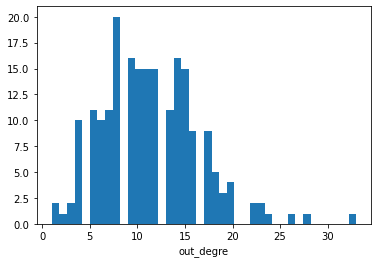

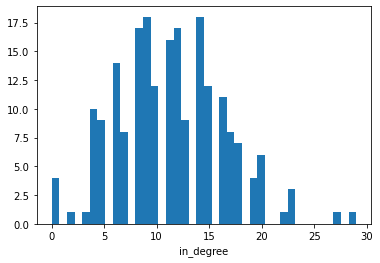

In [88]:
plt.hist(out_degree,40)
plt.xlabel('out_degre')
plt.show()
plt.hist(in_degree,40)
plt.xlabel('in_degree')
plt.show()

In [89]:
node_color = {
        NodeType.Common: "skyblue",
        NodeType.Influencer: "gold",
        NodeType.Bot: "purple"
    }
def draw_initial_network(network):
        figure = plt.figure(figsize=(12, 8))
        G = nx.DiGraph()
        pos = {}
        color_map = []
        for n, node in network.nodes.items():
            G.add_node(n)
            pos[n] = [node.position_x, node.position_y]
            color_map.append(node_color[node.type])

        for a, node in network.nodes.items():
            for b in node.adj:
                G.add_edge(a, b.dest)
        nx.draw(G, pos=pos, with_labels=True, font_size=8, node_size=150, node_color=color_map, edge_color="grey")


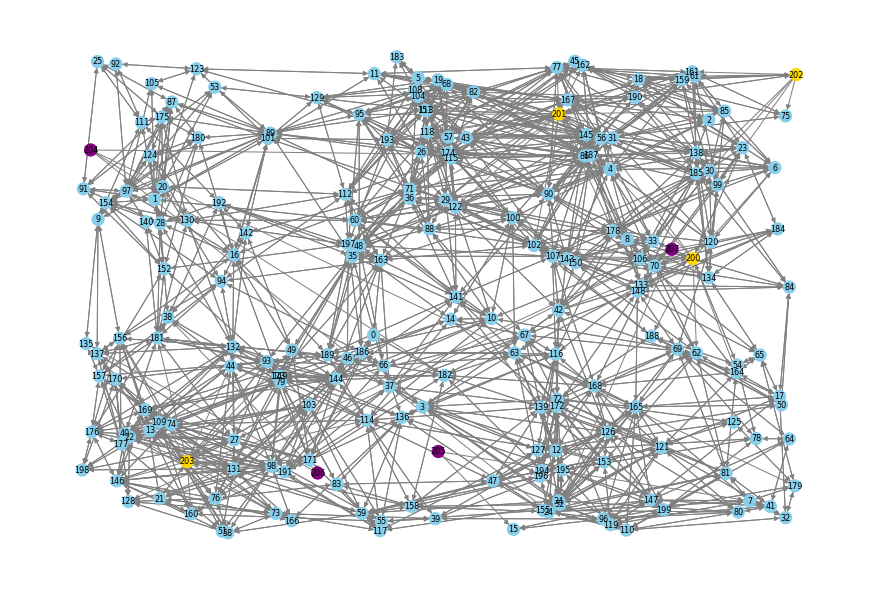

In [97]:
draw_initial_network(network)

In [98]:
def draw_simulation_network(network):
    figure = plt.figure(figsize=(12, 8))
    G = nx.DiGraph()
    pos = {}
    color_map = []
    for n, node in network.nodes.items():
        G.add_node(n)
        pos[n] = [node.position_x, node.position_y]
        if 0.5 > node.score > -0.5:
            color_map.append("skyblue")
        elif node.score > 0.5:
            color_map.append("red")
        else:
            color_map.append("blue")
    for a, node in network.nodes.items():
        for b in node.adj:
            G.add_edge(a, b.dest)
    nx.draw(G, pos=pos, with_labels=True, font_size=8, node_size=150, node_color=color_map, edge_color="grey")

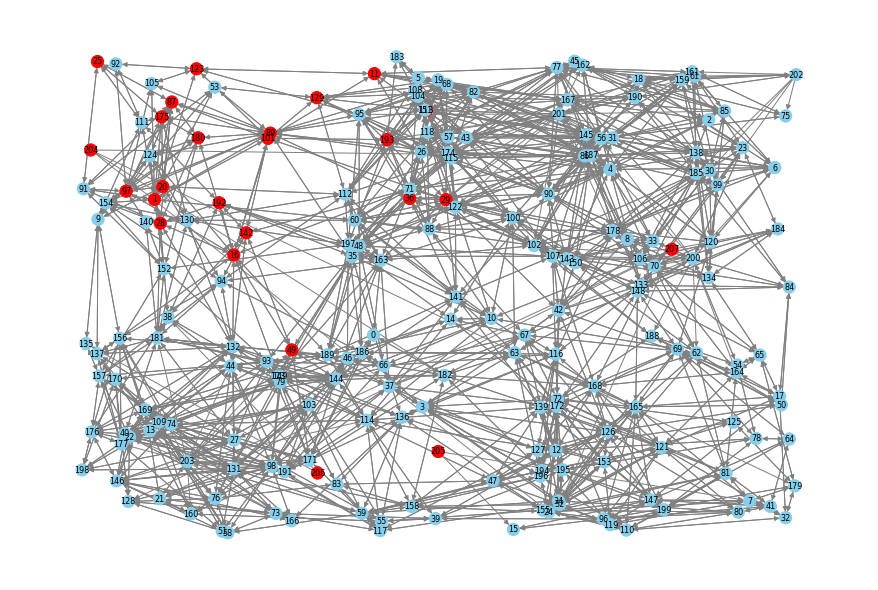

In [99]:
sim_results=simu.simulate(60)   ##will return the history of network at every 20 iteration
draw_simulation_network(sim_results[-1][1]) ###get the last network after simulation

In [121]:
#################################below is older parallel work 

In [ ]:
class VisualizeNetwork:
    def __init__(self):
        super().__init__()
        # Add plot canvas
        self.figure = plt.figure()
        self.network_canvas = FigureCanvas(self.figure)
        self.init_parameters()

        self.simulator = None
        self.sim_results = None
        self.n_sim_results = None

    def create_network(self, skip_draw=False):
        self.n_common = 200
        self.n_influencer = 3
        self.n_bots = 3
        self.engagement_news = 1.0
        self.random_const = 0.05


        self.simulator = Simulator(N_common=self.n_common, N_influencers=self.n_influencer, N_bots=self.n_bots, engagement_news=self.engagement_news, random_const=self.random_const)

        self.simulator.add_influencers()
        self.simulator.add_bots()

        if not skip_draw:
            self.draw_network()
    def init_parameters(self):
        self.n_common = 200
        self.n_influencer = 3
        self.n_bots = 3
        self.engagement_news = 1.0
        self.random_const = 0.05

        self.SIR = True
        self.weighted = False
        self.recovered_debunking = True

    node_color = {
        NodeType.Common: "skyblue",
        NodeType.Influencer: "lightgreen",
        NodeType.Bot: "plum"
    }
    
    def draw_network(self):
        self.figure.clf()

        G = nx.DiGraph()

        pos = {}
        color_map = []
        for n, node in network.nodes.items():
            G.add_node(n)
            pos[n] = [node.position_x, node.position_y]
            color_map.append(self.node_color[node.type])

        edge_labels = []
        for a, node in network.nodes.items():
            for b in node.adj:
                G.add_edge(a, b.dest)
                edge_labels.append(b)

        plt.figure(self.figure.number)
        nx.draw(G, pos=pos, with_labels=True, font_size=8, node_size=150, node_color=color_map, edge_color="grey")

        edges_artists = self.figure.get_axes()[0].patches

        def annotate_edges(event, ind, **kargs):
            if ind is None:
                idx = edges_artists.index(event.artist)
                edge = edge_labels[idx]
                return "{} - {}\nWeight: {:.3f}".format(edge.start, edge.dest, edge.weight)
            else:
                idx = ind[0]
                node = self.network.nodes[idx]
                node_type = str(node.type).split('.')[1]
                return "Node: {}\nType: {}\nScore: {:.3f}".format(idx, node_type, node.score)


        self.network_canvas.draw_idle()

    def draw_simulation_network(self, network):
        
        self.figure.clf()

        G = nx.DiGraph()

        pos = {}
        color_map = []
        for n, node in network.nodes.items():
            G.add_node(n)
            pos[n] = [node.position_x, node.position_y]
            if 0.5 > node.score > -0.5:
                color_map.append("skyblue")
            elif node.score > 0.5:
                color_map.append("tomato")
            else:
                color_map.append("gold")

        edge_labels = []
        for a, node in network.nodes.items():
            for b in node.adj:
                G.add_edge(a, b.dest)
                edge_labels.append(b)

        plt.figure(self.figure.number)
        nx.draw(G, pos=pos, with_labels=True, font_size=8, node_size=150, node_color=color_map, edge_color="grey")

        edges_artists = self.figure.get_axes()[0].patches

        def annotate_edges(event, ind, **kargs):
            if ind is None:
                idx = edges_artists.index(event.artist)
                edge = edge_labels[idx]
                return "{} - {}\nWeight: {:.3f}".format(edge.start, edge.dest, edge.weight)
            else:
                idx = ind[0]
                node = self.simulator.network.nodes[idx]
                node_type = str(node.type).split('.')[1]
                return "Node: {}\nType: {}\nScore: {:.3f}".format(idx, node_type, node.score)


        self.network_canvas.draw()

    def calc_engagement(self, t, max_time, initial_val=1.0):
        return initial_val * exp(-1 / (max_time / 2) * t)
        
    def run_simulation(self):
        # if self.simulator is None:
        #     return
        # self.simulator = Simulator(N_common=self.n_common, N_influencers=self.n_influencer, N_bots=self.n_bots, random_const=self.random_const)
        self.n_sim_results = None
        self.sim_time = 750
        self.engagement_news = 1.0
        self.simulator.engagement_news = partial(self.calc_engagement, initial_val=self.engagement_news, max_time=self.sim_time)
        #print(self.sim_time)

        self.sim_results = self.simulator.simulate(self.sim_time, SIR=self.SIR, recovered_debunking=self.recovered_debunking, weighted=self.weighted)
        for i, net in enumerate(self.sim_results):
            self.draw_simulation_network(net[1])
        self.show_results_window()
            
    def run_n_simulations(self):
        self.sim_results = None
        self.sim_time = 750
        self.engagement_news = 1.0
        self.simulator.engagement_news = partial(self.calc_engagement, initial_val=self.engagement_news,max_time=self.sim_time)
        self.n_sim_results = []
        n_nodes = len(network.nodes)
        for n in range(n_nodes):
            for i in range(n_sim):
                self.n_sim_results.append(simulator.simulate(self.sim_time, SIR=self.SIR, first_infect=n, recovered_debunking=self.recovered_debunking, weighted=self.weighted))
        self.show_results_window()
            
    def show_results_window(self):
        if self.sim_results is None and self.n_sim_results is None:
            return
        res = VisualizeNetwork(self.sim_results, self.n_sim_results, self.SIR, self)
        res.show()

In [ ]:
class Results:
    def __init__(self, sim_results, n_sim_results, SIR=False, *args, **kwargs):
        super(Results, self).__init__(*args, **kwargs)

        self.SIR = SIR

        if sim_results is not None:  # single simulation
            self.plot_sim_results(sim_results)
        else:
            self.plot_n_sim_results(n_sim_results)
   
    def plot_sim_results(self, sim_results):
        simulation_time = [net[0] for net in sim_results]

#         lbl = QLabel('SIR plot')
#         lbl.setAlignment(QtCore.Qt.AlignCenter)
#         lbl.setFont(QtGui.QFont("Arial", 12, QtGui.QFont.Bold))
#         self.layout.addWidget(lbl, 0, 0)
        score_figure = plt.figure()
        score_canvas = FigureCanvas(score_figure)
        self.layout.addWidget(score_canvas, 1, 0)
        infected = [net[1].count_score_equal(0.4, 1) for net in sim_results]
        neutral = [net[1].count_score_equal(-0.4, 0.4) for net in sim_results]
        recovered = [net[1].count_score_equal(-1.1, -0.4) for net in sim_results]
        plt.plot(simulation_time, infected, label="Infected")
        plt.plot(simulation_time, neutral, label="Neutral")
        plt.plot(simulation_time, recovered, label="Recovered")
        plt.legend()
        
        scores_start_figure = plt.figure()
        scores_start_canvas = FigureCanvas(scores_start_figure)
        self.layout.addWidget(scores_start_canvas, 3, 0)
        scores_start = list(map(lambda n: sim_results[0][1].nodes[n].score, sim_results[0][1].nodes))
        plt.hist(scores_start)
        plt.xlabel("Node scores")
        
        scores_end_figure = plt.figure()
        scores_end_canvas = FigureCanvas(scores_end_figure)
        self.layout.addWidget(scores_end_canvas, 3, 1)
        scores_end = list(map(lambda n: sim_results[-1][1].nodes[n].score, sim_results[-1][1].nodes))
        plt.hist(scores_end)
        plt.xlabel("Node scores")
        
    def plot_n_sim_results(self, n_sim_results):
        simulation_time = [net[0] for net in n_sim_results[0]]

        n = len(n_sim_results)

        def mean(vals):
            return sum(vals) / len(vals)

        # lbl = QLabel('SIR plot with {} simulations'.format(n))
        # lbl.setAlignment(QtCore.Qt.AlignCenter)
        # lbl.setFont(QtGui.QFont("Arial", 12, QtGui.QFont.Bold))
        # self.layout.addWidget(lbl, 0, 0)
        score_figure = plt.figure()
        score_canvas = FigureCanvas(score_figure)
        self.layout.addWidget(score_canvas, 1, 0)
        infected = [[sim[i][1].count_score_equal(0.4, 1) for sim in n_sim_results] for i in range(len(simulation_time))]
        infected = [mean(score) for score in infected]
        neutral = [[sim[i][1].count_score_equal(-0.4, 0.4) for sim in n_sim_results] for i in range(len(simulation_time))]
        neutral = [mean(score) for score in neutral]
        recovered = [[sim[i][1].count_score_equal(-1.1, -0.4) for sim in n_sim_results] for i in range(len(simulation_time))]
        recovered = [mean(score) for score in recovered]
        plt.plot(simulation_time, infected, label="Infected")
        plt.plot(simulation_time, neutral, label="Neutral")
        plt.plot(simulation_time, recovered, label="Recovered")
        plt.legend()
        
        scores_start_figure = plt.figure()
        scores_start_canvas = FigureCanvas(scores_start_figure)
        self.layout.addWidget(scores_start_canvas, 3, 0)
        scores_start = list(map(lambda n: n_sim_results[0][0][1].nodes[n].score, n_sim_results[0][0][1].nodes))
        plt.hist(scores_start)
        plt.xlabel("Node scores")
        
        scores_end_figure = plt.figure()
        scores_end_canvas = FigureCanvas(scores_end_figure)
        self.layout.addWidget(scores_end_canvas, 3, 1)
        scores_end = [
            mean(list(map(lambda n: sim[-1][1].nodes[n].score, sim[-1][1].nodes))) for sim in n_sim_results
        ]
        plt.hist(scores_end)
        plt.xlabel("Node scores")

    def show_results_window(self):
        res = Results(self.sim_results, self.n_sim_results, self.SIR, self)
        res.show()

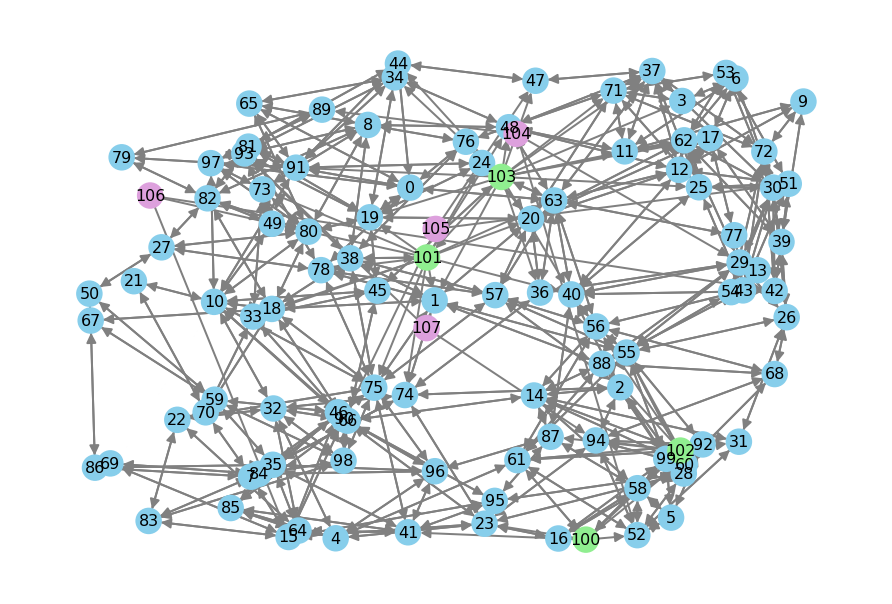

In [65]:
nw = VisualizeNetwork();
nw.draw_network();

In [66]:
nw = VisualizeNetwork();
nw.run_simulation();

AttributeError: 'NoneType' object has no attribute 'engagement_news'

<Figure size 864x576 with 0 Axes>

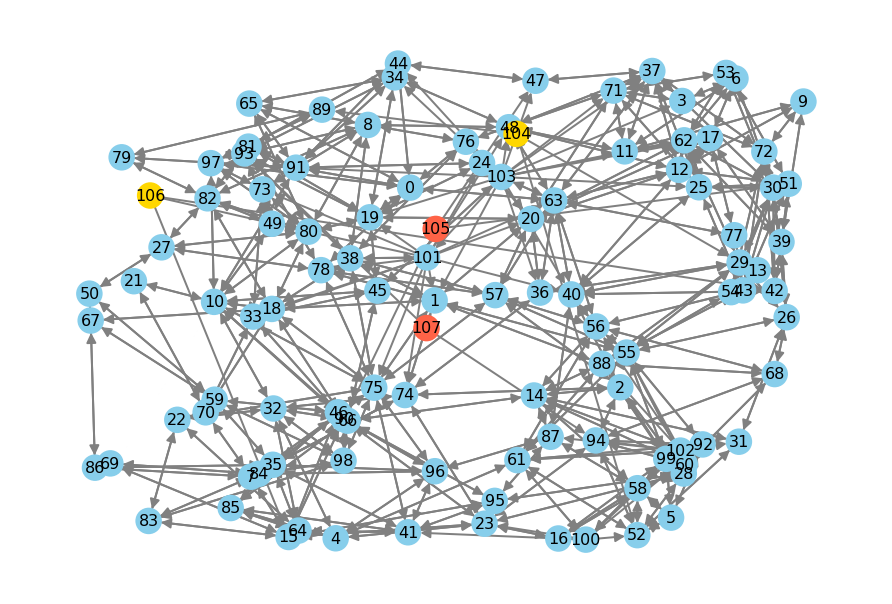

In [67]:
nw = VisualizeNetwork();
nw.draw_simulation_network(network);

In [70]:
 self.n_sim_results = None
        self.sim_time = 750
        self.engagement_news = 1.0
        self.simulator.engagement_news = partial(self.calc_engagement, initial_val=self.engagement_news, max_time=self.sim_time)
        #print(self.sim_time)

        self.sim_results = self.simulator.simulate(self.sim_time, SIR=self.SIR, recovered_debunking=self.recovered_debunking, weighted=self.weighted)
        for i, net in enumerate(self.sim_results):
            self.draw_simulation_network(net[1])
        self.show_results_window()

NameError: name 'sim_results' is not defined